In [95]:
import numpy as np
import pandas as pd

In [96]:
network_data = pd.read_csv("E:\data_science_classes\Train.txt", header = None)
network_test = pd.read_csv("E:\data_science_classes\Test.txt", header = None)

In [97]:
list_col = ["duration","protocol_type","service","flag","src_bytes","dst_bytes","land", "wrong_fragment","urgent","hot","num_failed_logins","logged_in", "num_compromised","root_shell","su_attempted","num_root","num_file_creations", "num_shells","num_access_files","num_outbound_cmds","is_host_login", "is_guest_login","count","srv_count","serror_rate", "srv_serror_rate", "rerror_rate","srv_rerror_rate","same_srv_rate", "diff_srv_rate",
"srv_diff_host_rate","dst_host_count","dst_host_srv_count","dst_host_same_srv_rate", "dst_host_diff_srv_rate","dst_host_same_src_port_rate", "dst_host_srv_diff_host_rate","dst_host_serror_rate","dst_host_srv_serror_rate", "dst_host_rerror_rate","dst_host_srv_rerror_rate","attack", "last_flag"]

In [98]:
network_data.rename(columns= { k:v for (k,v) in zip(network_data.columns, list_col)}, inplace = True)
network_test.rename(columns= { k:v for (k,v) in zip(network_test.columns, list_col)}, inplace = True)

In [100]:
dos =["back", "land" , "neptune", "pod", "smurf", "teardrop", "apache2", "udpstorm", "processtable", "worm"] 
probe = ["satan","ipsweep", "nmap", "portsweep", "mscan", "saint"]
r2l =["guess_passwd","ftp_write","imap","phf","multihop","warezmaster","warezclient","spy","xlock","xsnoop","snmpguess","snmpgetattack","httptunnel","sendmail","named"]
u2r = ["buffer_overflow", "loadmodule", "rootkit", "perl","sqlattack", "xterm","ps","mailbomb"]

In [101]:
for i in list(network_data.index):
    if list(network_data.loc[[i],["attack"]].attack)[0] == "normal":
        network_data.loc[[i],["attack"]] = 0 
    elif  list(network_data.loc[[i],["attack"]].attack)[0] in dos:
        network_data.loc[[i],["attack"]] = 1
    elif list(network_data.loc[[i],["attack"]].attack)[0] in probe:
        network_data.loc[[i],["attack"]] = 2
    elif list(network_data.loc[[i],["attack"]].attack)[0] in r2l:
        network_data.loc[[i],["attack"]] = 3
    elif list(network_data.loc[[i],["attack"]].attack)[0] in u2r:
        network_data.loc[[i],["attack"]] = 4

In [102]:
for i in list(network_test.index):
    if list(network_test.loc[[i],["attack"]].attack)[0] == "normal":
        network_test.loc[[i],["attack"]] = 0 
    elif list(network_test.loc[[i],["attack"]].attack)[0] in dos:
        network_test.loc[[i],["attack"]] = 1
    elif list(network_test.loc[[i],["attack"]].attack)[0] in probe:
        network_test.loc[[i],["attack"]] = 2
    elif list(network_test.loc[[i],["attack"]].attack)[0] in r2l:
        network_test.loc[[i],["attack"]] = 3
    elif list(network_test.loc[[i],["attack"]].attack)[0] in u2r:
        network_test.loc[[i],["attack"]] = 4

In [111]:
cat_col = []
num_col = []
for i in network_data.columns:
    if network_data[i].dtype.name in ['object']:
        cat_col.append(i)
    else:
        num_col.append(i)
num_col.remove("attack")

In [104]:
def outlier_treat(x,y):
    for i in x:
            y[i]= y[i].clip_upper(y[i].quantile(0.99)) 
            y[i]= y[i].clip_lower(y[i].quantile(0.01))     
outlier_treat(num_col,network_data)
outlier_treat(num_col,network_test)

In [106]:
def drop_0(j):
    zeros_col = []
    for i in j.columns:
        k = list(j[i].value_counts())
        if len(k)==1:
            j.drop(i, axis = 1, inplace = True)
drop_0(network_data)

In [107]:
network_data.shape

(125973, 30)

In [108]:
network_test = network_test[network_data.columns]

In [109]:
## Categorical Variable chi square test for variable selection
import scipy.stats as stats
chisq_df = pd.DataFrame()
for i in cat_col:
    cross_tab = pd.crosstab(network_data[i],network_data['attack'], margins=False)
    stats.chi2_contingency(observed=cross_tab)[1]
    temp = pd.DataFrame([i,stats.chi2_contingency(observed=cross_tab)[0],stats.chi2_contingency(observed=cross_tab)[1]]).T
    temp.columns = ['Variable', 'ChiSquare','P-Value']
    chisq_df = pd.concat([chisq_df, temp], axis=0, ignore_index=True)
chisq_df

,Variable,ChiSquare,P-Value
0,protocol_type,25578.4,0
1,service,156819,0
2,flag,120935,0


In [112]:
## Numerical Variable t test for variable selection
tstats_df = pd.DataFrame()
for i in num_col:
    tstats = stats.ttest_ind(network_data[network_data['attack']==1][i],network_data[network_data['attack']==0][i])
    temp = pd.DataFrame([i, tstats[0], tstats[1]]).T
    temp.columns = ['Variable Name', 'T-Statistic', 'P-Value']
    tstats_df = pd.concat([tstats_df, temp], axis=0, ignore_index=True)
tstats_df

,Variable Name,T-Statistic,P-Value
0,duration,-30.7718,4.49334e-207
1,src_bytes,3.17437,0.00150201
2,dst_bytes,-95.2909,0
3,hot,-3.74601,0.00017976
4,logged_in,-315.499,0
5,num_compromised,21.6752,5.72851e-104
6,count,327.579,0
7,srv_count,9.87121,5.66876e-23
8,serror_rate,426.401,0
9,srv_serror_rate,426.958,0


In [113]:
drop_ttest_col = list(tstats_df[tstats_df["P-Value"] >0.05]["Variable Name"])

In [114]:
drop_ttest_col

[]

In [115]:
#checking log likelihood

In [116]:
import statsmodels.formula.api as sm
llf_df = pd.DataFrame()
for i in num_col:
    data1 = pd.concat([network_data[network_data["attack"] == 1],network_data[network_data["attack"] == 0]], axis = 0)
    logreg = sm.logit(formula ="attack~" +i, data=data1)
    result = logreg.fit()
    summ = result.summary()
    temp = pd.DataFrame([i, result.llf]).T
    temp.columns = ['Variable Name','Log-Likelihood Full']
    llf_df = pd.concat([llf_df, temp], axis=0)

Optimization terminated successfully.
         Current function value: 0.643012
         Iterations 18
Optimization terminated successfully.
         Current function value: 0.675121
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.583294
         Iterations 9
Optimization terminated successfully.
         Current function value: 0.675103
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.390306
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.673132
         Iterations 5
Optimization terminated successfully.
         Current function value: 0.362632
         Iterations 7
Optimization terminated successfully.
         Current function value: 0.674741
         Iterations 4
Optimization terminated successfully.
         Current function value: 0.317612
         Iterations 8
Optimization terminated successfully.
         Current function value: 0.316064
 

In [117]:
llf_df.sort_values(by = "Log-Likelihood Full").head(8)

,Variable Name,Log-Likelihood Full
0,src_bytes,-76471
0,hot,-76468.9
0,srv_count,-76427.9
0,num_compromised,-76245.6
0,dst_host_diff_srv_rate,-75648.2
0,diff_srv_rate,-75149.8
0,dst_host_same_src_port_rate,-74996.6
0,rerror_rate,-74492.1


In [118]:
def dummies(k,j):
    x= []
    for i in k:
        x.append(pd.get_dummies(j[i], prefix ="d"))
    return(x)
cat_dum = dummies(cat_col,network_data)
cat_dum_t = dummies(cat_col,network_test)

In [119]:
cat_dum_df = pd.DataFrame(pd.concat(cat_dum, axis=1))
cat_dum_t_df = pd.DataFrame(pd.concat(cat_dum_t, axis=1))

In [120]:
num_df = network_data[num_col]
num_t_df = network_test[num_col]
num_t_df.head()

,duration,src_bytes,dst_bytes,hot,logged_in,num_compromised,count,srv_count,serror_rate,srv_serror_rate,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,last_flag
0,0.0,0.0,0.0,0.0,0.0,0.0,229.0,10.0,0.0,0.00,...,10.0,0.04,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21.0
1,0.0,0.0,0.0,0.0,0.0,0.0,136.0,1.0,0.0,0.00,...,1.0,0.00,0.06,0.00,0.00,0.0,0.0,1.00,1.00,21.0
2,2.0,12983.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.00,...,86.0,0.61,0.04,0.61,0.02,0.0,0.0,0.00,0.00,21.0
3,0.0,20.0,0.0,0.0,0.0,0.0,1.0,65.0,0.0,0.00,...,57.0,1.00,0.00,1.00,0.28,0.0,0.0,0.00,0.00,15.0
4,1.0,0.0,15.0,0.0,0.0,0.0,1.0,8.0,0.0,0.12,...,86.0,0.31,0.17,0.03,0.02,0.0,0.0,0.83,0.71,11.0


In [121]:
new_network_data= pd.concat([cat_dum_df,num_df], axis=1)
new_network_test= pd.concat([cat_dum_t_df,num_t_df], axis=1)

In [122]:
print(new_network_data.shape)
print(new_network_test.shape)

(125973, 110)
(22544, 104)


In [123]:
new_network_data= pd.concat([new_network_data,network_data.attack], axis=1)
new_network_test= pd.concat([new_network_test,network_test.attack], axis=1)

In [124]:
common_var = []
for i in new_network_test.columns:
    if i in new_network_data.columns:
        common_var.append(i)

In [125]:
new_network_test = new_network_test[common_var]
new_network_data = new_network_data[common_var]

In [126]:
#multi colinear from pandas profiling
drp_col = ["dst_host_rerror_rate","dst_host_srv_rerror_rate","dst_host_serror_rate",
           "dst_host_srv_serror_rate","srv_serror_rate","srv_rerror_rate","d_S0"]
new_network_data.drop(drp_col,axis=1,inplace= True)
new_network_test.drop(drp_col,axis=1,inplace= True)

In [127]:
print(new_network_data.shape)
print(new_network_test.shape)

(125973, 98)
(22544, 98)


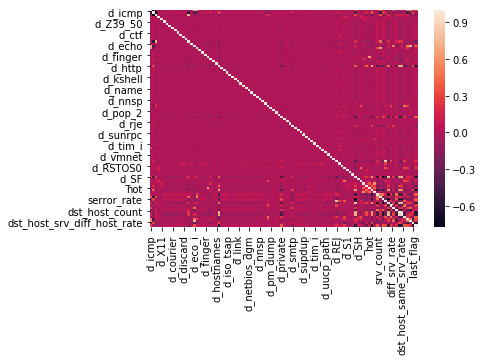

In [128]:
import seaborn as sns
corr_all = new_network_data.corr()
sns.heatmap(corr_all)

In [129]:
corr_y = corr_all["attack"]
corr_y_df = pd.DataFrame(corr_y)
corr_y_df.head()

,attack
d_icmp,0.292874
d_tcp,-0.057783
d_udp,-0.155004
d_IRC,-0.031346
d_X11,-0.014244


In [130]:
corr_y_df["attack"] = np.abs(corr_y_df["attack"])
corr_y_df.head(7)

,attack
d_icmp,0.292874
d_tcp,0.057783
d_udp,0.155004
d_IRC,0.031346
d_X11,0.014244
d_Z39_50,0.052353
d_auth,0.024511


In [131]:
corr_y_df = corr_y_df.sort_values(by= "attack", ascending= True)
corr_y_df.head(5)

,attack
d_tim_i,0.002296
d_tftp_u,0.004043
d_S3,0.009961
srv_diff_host_rate,0.010456
d_pm_dump,0.012935


In [132]:
corr_y_df.reset_index(inplace = True)


In [133]:
corr_y_df.head()

,index,attack
0,d_tim_i,0.002296
1,d_tftp_u,0.004043
2,d_S3,0.009961
3,srv_diff_host_rate,0.010456
4,d_pm_dump,0.012935


In [134]:
drop_corr = []
for i in list(corr_y_df.attack):
    if i < 0.01:
        for k in corr_y_df.index:
            if corr_y_df.loc[k,"attack"] == i:
                drop_corr.append(corr_y_df.loc[k,"index"])
for i in drop_corr:
    new_network_data.drop(i, inplace = True, axis = 1)

In [135]:
new_network_data.shape

(125973, 95)

In [136]:
#selecting all columns except y column
feature_columns = new_network_data.columns.difference( ["attack"] )

In [137]:
#splitting test and train data
train_X = new_network_data[feature_columns]
test_X = new_network_test[feature_columns]                                               
train_y = new_network_data["attack"]                                       
test_y = new_network_test["attack"] 

### making model using sklearn

In [138]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression()
logreg.fit( train_X, train_y )

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\logistic.py:460: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [139]:
logreg.predict(test_X)

array([1, 1, 0, ..., 1, 0, 2], dtype=int64)

In [140]:
#Predicting the test cases
network_test_pred = pd.DataFrame({ 'actual':  test_y,
                            'predicted': logreg.predict(test_X)})
network_test_pred.sample(10)

,actual,predicted
18712,0,0
14032,1,1
12128,0,0
21035,0,0
17227,1,1
12021,0,0
4154,0,0
17354,2,2
18099,2,2
20251,1,0


In [141]:
# Creating a confusion matrix
from sklearn import metrics
cm = metrics.confusion_matrix(network_test_pred.actual, network_test_pred.predicted)
cm

array([[8915,  519,  269,    8,    0],
       [1023, 6058,   49,   35,    2],
       [ 133,  202, 2078,    7,    1],
       [1570,   24,  231, 1016,   44],
       [ 297,    2,    2,   30,   29]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

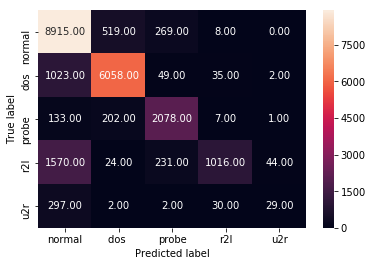

In [142]:
import matplotlib.pyplot as plt
import seaborn as sbn
%matplotlib inline
sbn.heatmap(cm, annot=True,  fmt='.2f', xticklabels = ["normal","dos ","probe","r2l","u2r"] , yticklabels = ["normal","dos","probe","r2l","u2r"] )
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [143]:
import sklearn.metrics as metrics
#also using sklearn.metrics
score = metrics.accuracy_score( network_test_pred.actual, network_test_pred.predicted )
score

0.8026969481902059

### making model using decision tree

In [145]:
import sklearn.tree as dt
import sklearn.ensemble as en
from sklearn import metrics
from sklearn.tree import DecisionTreeClassifier, export_graphviz, export

In [146]:
dt_network_data= pd.concat([cat_dum_df,num_df], axis=1)
dt_network_test= pd.concat([cat_dum_t_df,num_t_df], axis=1)

In [147]:
dt_network_data= pd.concat([dt_network_data,network_data.attack], axis=1)
dt_network_test= pd.concat([dt_network_test,network_test.attack], axis=1)

In [148]:
common_var = []
for i in dt_network_test.columns:
    if i in dt_network_data.columns:
        common_var.append(i)

In [149]:
dt_network_data=dt_network_data[common_var]
dt_network_test=dt_network_test[common_var]

In [150]:
#selecting all columns except y column
feature_columns_dt = dt_network_data.columns.difference( ["attack"] )

In [151]:
train_X_dt = dt_network_data[feature_columns_dt]
test_X_dt = dt_network_test[feature_columns_dt]                                               
train_y_dt = dt_network_data["attack"]                                       
test_y_dt = dt_network_test["attack"] 

In [172]:
network_data_tree = DecisionTreeClassifier( max_depth = 15,max_features= 90 )
network_data_tree.fit( train_X_dt, train_y_dt )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=15,
            max_features=90, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [173]:
tree_test_pred = pd.DataFrame( { 'actual':  test_y_dt,
                            'predicted': network_data_tree.predict( test_X_dt )  } )

In [174]:
metrics.accuracy_score( tree_test_pred.actual, tree_test_pred.predicted )

0.7853087295954577

In [175]:
cm_dt = metrics.confusion_matrix(tree_test_pred.actual,tree_test_pred.predicted )
cm_dt

array([[9440,   55,  214,    1,    1],
       [1125, 5814,  226,    0,    2],
       [ 389,  208, 1824,    0,    0],
       [2023,    5,  222,  598,   37],
       [ 101,    0,  205,   26,   28]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

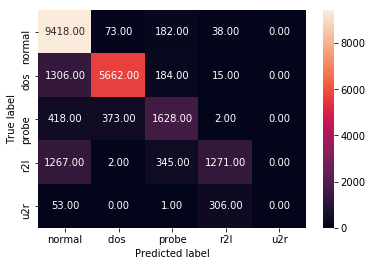

In [167]:
sbn.heatmap(cm_dt, annot=True,  fmt='.2f', xticklabels = ["normal","dos ","probe","r2l","u2r"] , yticklabels = ["normal","dos","probe","r2l","u2r"])
plt.ylabel('True label')
plt.xlabel('Predicted label')

In [161]:
#fine tuning the parameters

In [162]:
from sklearn.model_selection import GridSearchCV

In [176]:
param_grid = {'max_depth': np.arange(9, 20),
             'max_features': np.arange(70,90)}

In [177]:
tree = GridSearchCV(DecisionTreeClassifier(), param_grid, cv = 10)
tree.fit( train_X_dt, train_y_dt )

GridSearchCV(cv=10, error_score='raise-deprecating',
       estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'max_depth': array([ 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]), 'max_features': array([70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86,
       87, 88, 89])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [178]:
tree.best_params_

{'max_depth': 18, 'max_features': 85}

In [179]:
tree.best_score_

0.998793392234844

In [259]:
new_network_data_tree = DecisionTreeClassifier( max_depth = 18, max_features = 85)
new_network_data_tree.fit( train_X_dt, train_y_dt )

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=18,
            max_features=85, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [260]:
new_tree_test_pred = pd.DataFrame( { 'actual':  test_y_dt,
                            'predicted': new_network_data_tree.predict( test_X_dt )  } )

In [261]:
metrics.accuracy_score( new_tree_test_pred.actual, new_tree_test_pred.predicted )

0.7983498935415189

In [262]:
new_cm_dt = metrics.confusion_matrix(new_tree_test_pred.actual,new_tree_test_pred.predicted )
new_cm_dt

array([[9401,   34,  272,    4,    0],
       [ 902, 6047,  214,    4,    0],
       [ 481,  197, 1743,    0,    0],
       [1658,    0,  403,  786,   38],
       [ 113,    0,  205,   21,   21]], dtype=int64)

Text(0.5, 15.0, 'Predicted label')

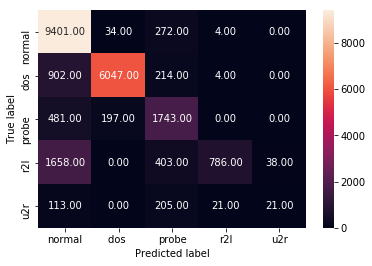

In [263]:
sbn.heatmap(new_cm_dt, annot=True,  fmt='.2f', xticklabels = ["normal","dos ","probe","r2l","u2r"] , yticklabels = ["normal","dos","probe","r2l","u2r"])
plt.ylabel('True label')
plt.xlabel('Predicted label')